# T038 · Protein Ligand Interaction Prediction

**Note:** This talktorial is a part of TeachOpenCADD, a platform that aims to teach domain-specific skills and to provide pipeline templates as starting points for research projects.

Authors:

- Roman Joeres, 2022, [Chair for Drug Bioinformatics, UdS and HIPS](https://www.helmholtz-hips.de/de/forschung/teams/team/wirkstoffbioinformatik/)

## Aim of this talktorial

The goal of this talktorial is to introduce the reader to the field of protein ligand interaction prediction using graph neural networks (GNNs). GNNs are especially useful for representing structural data such as proteins and chemical molecules (ligands) to a deep learning model. In this talktorial, I will show how to train a deep learning model to predict interactions between proteins and ligands.

### Contents in *Theory*

* Relevance of Protein Ligand Interaction Prediction
* Workflow
* Biological background - Proteins as Graphs
* Technical background
  * Graph Isomorphism Networks
  * Binary Cross Entropy Loss

### Contents in *Practical*

* Compute graph representations
  * Ligands to graphs
  * Proteins to graphs
* Data Storages
  * Data Points
  * Data Set
  * Data Module
* Network
  * GNN Encoder
  * Full Model
* Training routine

### References

* Theoretical background
    * Graph Neural Networks:
      Kipf, Welling: "Semi-Supervised Classification with Graph Convolutional Networks", [<i>arXiv</i> (2017)](https://arxiv.org/abs/1609.02907)
      Bronstein, et al.: "Geometric deep learning: going beyond Euclidean data", [<i>IEEE Signal Processing Magazine</i> (2017), <b>4</b>, 18-42](https://doi.org/10.1109/MSP.2017.2693418)
    * GNN based Protein Ligand Interaction Prediction:
      Öztürk, et al.: "DeepDTA: Deep drug-target binding affinity prediction", [<i>Bioinformatics</i> (2018), <b>34</b>, i821-i829](https://doi.org/10.1093/bioinformatics/bty593)
      Nguyen, et. al.: "GraphDTA: Predicting drug target binding affinity with graph neural networks", [<i>Bioinformatics</i> (2021), <b>37</b>, 1140-1147](https://doi.org/10.1093/bioinformatics/btaa921)
    * Graph Isomorphism Network:
      Xu, et al.: "How powerful are graph neural networks?", [<i>arXiv</i> (2018)](https://arxiv.org/abs/1810.00826)

* Practical Background
    * [PyTorch](https://pytorch.org/)
    * [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/)
    * [RDKit](http://rdkit.org/): Greg Landrum, *RDKit Documentation*, [PDF](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf), Release on 2019.09.1.

## Theory

This talktorial combines several topics, you have seen in other talktorials. Here, I will describe the general idea of how to predict interactions between proteins and ligands. If some technique used in the workflow is already presented somewhere else, I'll link to this otherwise, I'll explain new things below.

### Relevance of Protein Ligand Interaction Prediction
Protein-ligand interactions are of interest in research for many reasons as can be seen in [__Talktorial T016__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T016_protein_ligand_interactions/talktorial.ipynb). One of the most important fields where being able to predict whether a certain pair of protein and ligand interact or not is the field of drug discovery. Classically, in drug development one want to find a new drug given a protein target. For example in the CoVid-19 pandemic, most pharmacy companies tried to find drugs to bind to the spike protein. In order TBC.

### Workflow

Our input is a dataset comprising a set of proteins and a set of ligands and a table with binding information for every pair of proteins and ligands. Speaking in terms of supervised learning (as in [__Talktorial T022__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T022_ligand_based_screening_neural_networks/talktorial.ipynb)), our dataset we use for training, validation, and testing is the table of interaction data. One component of our network architecture is a simple Feed-forward Neural Network (FNN) as presented in [__Talktorial T022__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T022_ligand_based_screening_neural_networks/talktorial.ipynb). The other two components are graph neural networks (GNNs) to extract features from the proteins and ligands in each pair of the dataset. As discussed in [__Talktorial T034__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T034_link/talktorial.ipynb) GNNs are used to compute a representation of graph structured data that holds information about the structure. These representations are concatenated into one vector which serves as input for the final FNN.

![Basic structure](./images/basic_structure.png)

*Figure 1:*
Visualization of the workflow of the model in this notebook. The shown exemplary structures are taken from from the PDB entry with ID 4O75.

### Biological background - Proteins as Graphs

Here, I will focus on the conversion of proteins into graphs as the conversion of SMILES to graphs is explained in [__Talktorial T034__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T022_ligand_based_screening_neural_networks/talktorial.ipynb).

There are usually two ways to represent proteins in science. Either by their sequence of amino acids or as a PDB structure as introduced in [__Talktorial T008__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T008_query_pdb/talktorial.ipynb). As amino acid sequences do not contain structural information, in protein ligand interaction prediction we use PDB files of proteins as input for our structure-based models. In the graph representation of a protein, every node of the graph represents an amino acid from the protein. Edges between nodes in the graph are drawn if the two represented amino acids are within a certain distance. This is the equivalent of an interaction between the two amino acids in teh protein. To compute the distance of two amino acids, we look at the coordinates of the $C_\alpha$ atoms of the amino acids in the PDB file. If the distance between two $C_\alpha$ atoms is below a certain distance threshold, we consider the amino acids to interact and insert an edge in the graph representation of the protein. This can be seen in Figure 2.

![Prot2Graph](./images/prot_graph_creation.png)

*Figure 2:*
Visualization of the process and idea of protein representation as graphs. For this example, we consider only the $C_\alpha$ atoms of the cysteins to be withing a distance threshold of 7 Angstrom. As both cysteins are spatially close, their sulfates generate a disulfate bridge and stabilizes the protein three-dimensions structure which is the type of interaction we want to have in the graph representations.

### Technical background

In this section, I will focus on the computer science aspects of the proposed solution. Mainly, I'll discuss the concrete GNN architecture to use and which node features I use.

#### Graph Isomorphism Networks

There is a whole zoo of GNN architectures proposed to solve many problems. If you want to get an overview over the most popular architectures, you can have a look at the [list of convolutional layers implemented in PyTorch-Geometric](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers). In this talktorial, we will use the GINConv layers as backbone of out GNNs as they have been proven to be powerful in embedding molecular data yet remaining easy to understand in their functionality. The formula to compute an embedding of a node based on the neighbors is
$$\mathbf{x}^{\prime}_i = h_{\mathbf{\Theta}} \left( (1 + \epsilon) \cdot \mathbf{x}_i + \sum_{j \in \mathcal{N}(i)} \mathbf{x}_j \right)$$
where $\mathcal{N}(i)$ is the set of neighbors of node $i$, $\epsilon$ is just a constant, and $h_{\mathbf{\Theta}}$ is a neural network as presented in [__Talktorial T022__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T022_ligand_based_screening_neural_networks/talktorial.ipynb). The idea is to aggregate all neighbor embeddings together with the own current embedding and put this into a neural network to extract information on the nodes and it's neighborhood.

As can be seen, GINConv layers do not use edge information in their computation. So, the only thing we need to extract from out proteins and ligands when turning into graphs are features for the edges. In this talktorial, we will use a very simple featurization and every node just contains categorical information on the amino acid type or atom type is represents. Information on onehot encodings of categorical data is covered in [__Talktorial T021__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T022_one_hot_encoding/talktorial.ipynb).

The final element to finalize our GNN module is the pooling function, that is used to compute the graph embedding based on the node embeddings in the final layer. For simplicity reasons (and because it's surprisingly powerful) we use mean pooling. That means, we just take the mean vector over all node embeddings in the final GINConv layer.

#### Binary Cross Entropy Loss

[__Talktorial T022__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T022_ligand_based_screening_neural_networks/talktorial.ipynb) introduces two loss functions, namely MSE and MAE. Both are suitable to train regression models but not appropriate for classification. For classification there is wide range of loss functions of which we will use the [Binary Cross Entropy Loss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html).

The formula to compute the loss is
$$-\left[ y\cdot\log x+(1-y)\cdot\log (1-x)\right],$$
where $x$ is the models output for one sample and $y$ is the label of that sample.

The idea is that exactly one term of $y$ and $1-y$ equals $1$ to the formula reduces to $\log x$ for a positive sample and $\log (1-x)$ for a negative example. By this setting, the BCE formula ensures that you want to push the predicted values $x$ towards 0 in negative samples ($y=0$) and towards $1$ in positive cases ($y=1$).

## Practical

In this practical section, we will discuss every step in implementing the above presented solution to protein ligand interaction prediction. We will start with all the imports needed and some path definitions.

In [1]:
import math
import random
import os
from pathlib import Path

from rdkit import Chem
import torch
import torch.nn.functional as F
from torch import Tensor, nn
from torch.optim import Adam
from torch_geometric.nn import global_mean_pool, GINConv
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

from kiba_analysis import kiba_preprocessing

C:\Users\joere\Desktop\Dokumente\Workspace\Python\teachopencadd\teachopencadd\talktorials\T038_protein_ligand_interaction_prediction\kiba_analysis.py:15: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,18,19,20,21,22,24,25,26,27,29,30,31,32,34,35,36,37,38,39,40,41,42,43,44,45,47,48,49,50,51,52,59,63,68,69,71,76,77,79,80,81,84,87,89,91,92,94,98,99,100,101,102,103,104,105,106,107,109,110,112,113,114,116,117,118,120,121,122,125,126,127,128,130,131,132,135,136,137,138,139,140,141,142,143,148,149,150,151,152,153,154,156,157,158,159,160,161,162,163,164,165,166,170,171,172,173,174,176,178,179,180,181,182,185,186,188,189,190,192,193,195,196,198,200,201,202,203,205,206,207,208,209,210,211,212,213,214,215,216,217,218,220,221,222,223,224,225,226,227,229,230,231,233,234,235,237,238,242,244,245,246,247,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,265,266,267,268,270,271,272,273,274,275,276,277,278,279,281,282,283,284,285,286,287,289,290,291,292,293,294,296,297,299,300,302,303

KiBA originally contains 52498 ligands and 468 proteins.
KiBA after dropping sparse rows contains 79 ligands and 468 proteins.
KiBA finally contains 79 ligands and 373 proteins.
Preprocessing ligands
After ligand availability analysis KiBA contains 76 ligands and 373 proteins.
Preprocessing ligands finished
Preprocessing proteins
After protein availability analysis KiBA contains 76 ligands and 275 proteins.
Preprocessing proteins finished
Preprocessing interactions


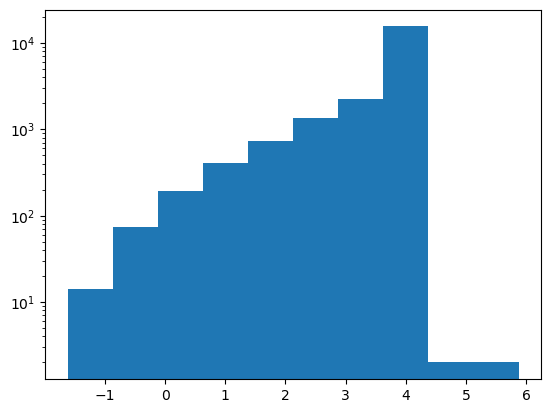

3.6122063690076973
3.6122063690076973
Finally, KiBA comprises 20475 interactions.
Preprocessing interactions finished


In [5]:
HERE = Path("./")
DATA = HERE / "data2"

kiba_preprocessing(f"{str(DATA)}/kiba/KIBA.csv", f"{str(DATA)}/resources/")

### Compute graph representations

#### Ligands to graphs

First, we're going to implement the conversion of ligands into graphs. For the following explaination, I assume the ligand has $N$ atoms. To encode a graph, we have to compute a matrix of the node features (a $N\times F$-matrix where $F$ is the number of features per node) and a matrix of the edges given by pairs of the participating node ids.

Due to some PyTorch Geometric related implementation details, the edge-matrix has to have the format $2\times N$.

In [6]:
# For every atom type we consider, map the symbol to a numerical value for onehot encoding.
atoms_to_num = dict((atom, i) for i, atom in enumerate([
    "C", "N", "O", "F", "P", "S", "Cl", "Br", "I"
]))


def atom_to_onehot(atom):
    """
    Return the onehot encoding for an atom given as it's index from the atoms_to_num dict.

    Parameters
    ----------
    atom: str
        Atomic symbol of the atom to represent

    Returns
    -------
    torch.Tensor
        A onehot tensor encoding the atoms features.
    """
    # initialize a 0-vector ...
    one_hot = torch.zeros(len(atoms_to_num) + 1, dtype=torch.float)
    # ... and set the according field to one, ...
    if atom in atoms_to_num:
        one_hot[atoms_to_num[atom]] = 1.0
    # ... the last field is used to represent atom types that do not have their own field in the onehot vector
    else:
        one_hot[len(atoms_to_num)] = 1.0
    return one_hot


def smiles_to_graph(smiles):
    """
    Convert a molecule given as SDF file into a graph.

    Arguments
    ---------
    smiles: str
        Path to the file storing the structural information of the ligand

    Returns
    -------
    Tuple[torch.Tensor, torch.Tensor]
        A pair of node features and edges in the PyTorch Geometric format
    """
    # read in the molecule from an SDF file
    mol = Chem.MolFromSmiles(smiles)
    atoms, bonds = [], []
    # check if the molecule is valid
    if mol is None:
        print(smiles)
        return None, None

    # iterate over all atom, compute the feature vector and store them in a torch.Tensor object
    for atom in mol.GetAtoms():
        atoms.append(atom_to_onehot(atom.GetSymbol()))
    atoms = torch.stack(atoms)

    # iterate over all bonds in the molecule and store them in the PyTorch Geometric specific format in a torch.Tensor,
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()))
        bonds.append((bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()))
    bonds = torch.tensor(bonds, dtype=torch.long).T

    return atoms, bonds

#### Proteins to graphs

Similar to how we converted ligands to graphs, we convert proteins into graphs. The output will be the same, a pair of node features and edges.

In [7]:
# Generate a mapping from amino acids to numbers for onehot encoding
aa_to_num = dict((aa, i) for i, aa in enumerate([
    "ALA", "ARG", "ASN", "ASP", "CYS", "GLU", "GLN", "GLY", "HIS", "ILE", "LEU", "LYS", "MET",  "PHE", "PRO",  "SER", "THR", "TRP", "TYR", "VAL", "UNK",
]))


def aa_to_onehot(aa):
    """
    Compute the onehot vector for an amino acid representing node.

    Arguments
    ---------
    aa: str
        The three-letter code of the amino acid to be represented

    Returns
    -------
    torch.Tensor
        A onehot tensor encoding the atoms features.
    """
    one_hot = torch.zeros(len(aa_to_num), dtype=torch.float)
    one_hot[aa_to_num[aa]] = 1.0
    return one_hot


def pdb_to_graph(pdb_file_path, max_dist=7.0):
    """
    Extract a graph representation of a protein from the PDB file.

    Arguments
    ---------
    pdb_file_path: str
        Filepath of the PDB file containing structural information on the protein
    max_dist: float
        Distance threshold to apply when computing edges between amino acids

    Returns
    -------
    Tuple[torch.Tensor, torch.Tensor]
        A pair of node features and edges in the PyTorch Geometric format
    """
    # read in the PDB file by looking for the Calpha atoms and extract their amino acid and coordinates based on the positioning in the PDB file
    residues = []
    with open(pdb_file_path, "r") as protein:
        for line in protein:
            if line.startswith("ATOM") and line[12:16].strip() == "CA":
                residues.append((
                    line[17:20].strip(),
                    float(line[30:38].strip()),
                    float(line[38:46].strip()),
                    float(line[46:54].strip()),
                ))
    # Finally compute the node features based on the amino acids in the protein
    node_feat = torch.stack([aa_to_onehot(res[0]) for res in residues])

    # compute the edges of the protein by iterating over all pairs of amino acids and computing their distance
    edges = []
    for i in range(len(residues)):
        res = residues[i]
        for j in range(i + 1, len(residues)):
            tmp = residues[j]
            if math.dist(res[1:4], tmp[1:4]) <= max_dist:
                edges.append((i, j))
                edges.append((j, i))

    # store the edges in the PyTorch Geometric format
    edges = torch.tensor(edges, dtype=torch.long).T

    return node_feat, edges

### Data Storages

Storing and representing data in PLI-prediction is a bit different from other neural networks. Therefore, we have to define our own classes to represent the data.

#### Data Points

Usually the built-in Data class of PyTorch Geometric is used to represent only one graph, for our task, the data contains two graphs, therefore, we need to adapt the functionality to compute the number of nodes and edges for one data point.

In [8]:
class DTIDataPair(Data):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @property
    def num_nodes(self):
        return self["lig_x"].size(0) + self["prot_x"].size(0)

    @property
    def num_edges(self):
        return self["lig_edge_index"].size(1) + self["prot_edge_index"].size(1)

    def __inc__(self, key, value, *args, **kwargs):
        """
        Method that is necessary to overwrite for successful batching of DTIDataPair object.
        In case of interest, one can look at this explanation:
        https://pytorch-geometric.readthedocs.io/en/latest/notes/batching.html

        When multiple samples are send through a network at once, they are aggregated into batches.
        In PyTorch Geometric this is done by copying all n graphs for one batch into one graph with
        n connected components. Because of this, the node ids in the edge_index objects have to be
        changed. As they have to be increased by a fix offset based on the number of nodes in the
        batch so far, this method computes this offset in case the edge_indices of either the
        proteins or ligands.

        Arguments
        ---------
        key: str
            String name of the field of this class to increment while batching

        Returns
        -------
        torch.Tensor
            A one-element tensor describing how to modify the values when batching.
        """
        if not key.endswith("edge_index"):
            return super().__inc__(key, value, *args, **kwargs)
        lenedg = len("edge_index")
        prefix = key[:-lenedg]
        return self[prefix + "x"].size(0)

#### Data Set

This is where the real data magic happens. In the dataset, we read in the data and process them into the graphical representation we want to have.

In [9]:
class DTIDataset(InMemoryDataset):
    def __init__(self, folder_name, file_index):
        self.folder_name = folder_name
        super().__init__(root=folder_name)
        self.data, self.slices = torch.load(self.processed_paths[file_index])

    @property
    def processed_file_names(self):
        """
        Just store the names of the files where the training split, validation split, and test split are stored.

        Returns
        -------
        List[str]
            A list of filenames where the preprocessed data is stored to not recompute the preprocessing every time.
        """
        return ["train.pt", "val.pt", "test.pt"]

    def process(self):
        """
        This function is called internally in the preprocessing routine of PyTorch Geometric and defined how the dataset of PDB files, ligands, and an interaction table is converted into a dataset of graphs, ready for deep learning.
        """
        # compute all ligand graphs and store them as a dictionary with their names as key and the graphs as values
        ligand_graphs = dict()
        with open(os.path.join(self.folder_name, "tables", "ligands.tsv"), "r") as data:
            for line in data.readlines()[1:]:
                chembl_id, smiles = line.strip().split("\t")[:2]
                ligand_graphs[chembl_id] = smiles_to_graph(smiles)

        # compute all protein graphs and store them as a dictionary with their names as key and the graphs as values
        protein_graphs = dict([
            (filename[:-4], pdb_to_graph(os.path.join(os.path.join(self.folder_name, "proteins", filename)))) for filename in os.listdir(os.path.join(self.folder_name, "proteins"))
        ])

        with open(os.path.join(self.folder_name, "tables", "inter.tsv")) as inter:
            data_list = []
            for line in inter.readlines()[1:]:
                # read a line with one interaction sample. Extract ligand and protein ID and get their graphs from the dictionaries above
                protein, ligand, y = line.strip().split('\t')
                lig_node_feat, lig_edge_index = ligand_graphs[ligand]
                prot_node_feat, prot_edge_index = protein_graphs[protein]

                # if either ligand or protein are invalid graphs, skip this sample ...
                if lig_node_feat is None or prot_node_feat is None:
                    print(line.strip())
                    continue

                # ... otherwise, create a datapoint using the class from above
                data_list.append(DTIDataPair(
                    lig_x=lig_node_feat,
                    lig_edge_index=lig_edge_index,
                    prot_x=prot_node_feat,
                    prot_edge_index=prot_edge_index,
                    y=torch.tensor(float(y), dtype=torch.float),
                ))

            # shuffle the data, and compute how many samples go into which split
            random.shuffle(data_list)
            train_frac = int(len(data_list) * 0.7)
            test_frac = int(len(data_list) * 0.1)

            # then split the data and store them for later reuse without running the preprocessing pipeline
            train_data, train_slices = self.collate(data_list[:train_frac])
            torch.save((train_data, train_slices), self.processed_paths[0])
            val_data, val_slices = self.collate(data_list[train_frac:-test_frac])
            torch.save((val_data, val_slices), self.processed_paths[1])
            test_data, test_slices = self.collate(data_list[-test_frac:])
            torch.save((test_data, test_slices), self.processed_paths[2])

#### Data Module

This is just a handy class holding all three splits of a dataset and providing data loaders for training, validation, and test.

In [10]:
class DTIDataModule:
    def __init__(self, folder_name):
        self.train = DTIDataset(folder_name, 0)
        self.val = DTIDataset(folder_name, 1)
        self.test = DTIDataset(folder_name, 2)

    def train_dataloader(self):
        """
        Create and return a dataloader for the training dataset.

        Returns
        -------
        torch_geometric.loaders.DataLoader
            Dataloader on the training dataset
        """
        return DataLoader(self.train, batch_size=64, shuffle=True, follow_batch=["prot_x", "lig_x"])

    def val_dataloader(self):
        """
        Create and return a dataloader for the validation dataset.

        Returns
        -------
        torch_geometric.loaders.DataLoader
            Dataloader on the validation dataset
        """
        return DataLoader(self.val, batch_size=64, shuffle=True, follow_batch=["prot_x", "lig_x"])

    def test_dataloader(self):
        """
        Create and return a dataloader for the test dataset.

        Returns
        -------
        torch_geometric.loaders.DataLoader
            Dataloader on the test dataset
        """
        return DataLoader(self.test, batch_size=64, shuffle=True, follow_batch=["prot_x", "lig_x"])

### Network

Here, we will implement the networks as defined in the theory section.

#### GNN Encoder

First, the GNN encoder which we will use for both, embedding proteins and embedding ligands.

In [11]:
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=64, num_layers=3):
        """
        Encoder to embed structural data using a stack of GINConv layers.

        Arguments
        ---------
        input_dim: int
            Size of the feature vector of the data
        hidden_dim: int
            Number of hidden neurons to use when computing the embeddings
        output_dim: int
            Size of the output vector of the final graph embedding after a final mean pooling
        num_layers: int
            Number of layers to use when computing embedding. This includes input and output layers, so values below 3 are meaningless.
        """
        super().__init__()
        self.layers = [
            # define the input layer
            GINConv(
                nn.Sequential(
                    nn.Linear(input_dim, hidden_dim),
                    nn.PReLU(),
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.BatchNorm1d(hidden_dim),
                )
            )
        ] + [
            # define a number of hidden layers
            GINConv(
                nn.Sequential(
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.PReLU(),
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.BatchNorm1d(hidden_dim),
                )
            )
            for _ in range(num_layers - 2)
        ] + [
            # define the output layer
            GINConv(
                nn.Sequential(
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.PReLU(),
                    nn.Linear(hidden_dim, output_dim),
                    nn.BatchNorm1d(output_dim),
                )
            )
        ]

    def forward(self, x, edge_index, batch):
        """
        Forward a batch of samples through this network to compute the forward pass.

        Arguments
        ---------
        x: torch.Tensor
            feature matrices of the graphs forwarded through the network
        edge_index: torch.Tensor
            edge indices of the graphs forwarded through the network
        batch: torch.Tensor
            Some internally used information, not relevant for the topic of this talktorial
        """
        for layer in self.layers:
            x = layer(x=x, edge_index=edge_index)
        pool = global_mean_pool(x, batch)
        return F.normalize(pool, dim=1)

#### Full Model

Define the full model according to the workflow proposed in the theory section.

In [12]:
class DTINetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # create encoders for both, proteins and ligands
        self.prot_encoder = Encoder(21)
        self.lig_encoder = Encoder(10)

        # define a simple FNN to compute the final prediction (to bind or not to bind)
        self.combine = torch.nn.Sequential(
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),

            torch.nn.Linear(256, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),

            torch.nn.Linear(64, 1),
            torch.nn.Sigmoid(),
        )

    def forward(self, data):
        """
        Define the standard forward process of this network.

        Arguments
        ---------
        data: DTIDataPairBatch
            A batch of DTIDataPair samples to be predicted to train on them

        Returns
        -------
        Prediction values for all pairs in the input batch
        """
        # compute the protein embeddings using the protein embedder on the protein data of the batch
        prot_embed = self.prot_encoder(
            x=data.prot_x,
            edge_index=data.prot_edge_index,
            batch=data.prot_x_batch,
        )

        # compute the ligand embeddings using the ligand embedder on the ligand data of the batch
        lig_embed = self.lig_encoder(
            x=data.lig_x,
            edge_index=data.lig_edge_index,
            batch=data.lig_x_batch,
        )

        # concatenate both embeddings and return the output of the FNN
        combined = torch.cat((prot_embed, lig_embed), dim=1)
        return self.combine(combined)

### Training Routine

In [13]:
def train(num_epochs=1):
    """
    Implementation of the actual training routine.

    Arguments
    ---------
    num_epochs: int
        Number of epochs to train the model
    """
    # load the data, model, and define the loss function
    dataset = DTIDataModule(DATA / "resources")
    model = DTINetwork()
    loss_fn = torch.nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=0.0001)
    epoch_train_acc, epoch_train_loss, epoch_val_acc, epoch_val_loss = [], [], [], []

    # train for num_epochs
    for e in range(num_epochs):
        print(f"Epoch {e + 1}/{num_epochs}")

        # perform the actual training
        train_loader = dataset.train_dataloader()
        for b, data in enumerate(train_loader):
            # compute the models predictions and the loss
            pred = model.forward(data).squeeze()
            loss = loss_fn(pred, data.y.squeeze())

            # perform one step of backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # report some statistics on the training batch
            pred = pred > 0.5
            epoch_train_acc.append(sum(pred == data.y) / len(pred))
            epoch_train_loss.append(loss.item())
            print(f"\rTraining step {(b + 1)}/{len(train_loader)}: Loss: {epoch_train_loss[-1]:.5f}\tAcc: {epoch_train_acc[-1]:.5f}", end="")

        torch.save(model.state_dict(), DATA / f"model_{e + 1}.pth")

        # perform validation of the last training epoch
        val_loader = dataset.val_dataloader()
        for b, data in enumerate(val_loader):
            # compute the models predictions and the loss
            pred = model.forward(data).squeeze()
            loss = loss_fn(pred, data.y.squeeze())

            # report some statistics on the validation batch
            pred = pred > 0.5
            epoch_val_acc.append(sum(pred == data.y) / len(pred))
            epoch_val_loss.append(loss.item())
            print(f"\rValidation step {(b + 1)}/{len(val_loader)}: Loss: {epoch_val_loss[-1]:.5f}\tAcc: {epoch_val_acc[-1]:.5f}", end="")

    # test the final model
    print()
    test_loss, test_acc = [], []
    val_loader = dataset.test_dataloader()
    for b, data in enumerate(val_loader):
        # compute the models predictions and the loss
        pred = model.forward(data).squeeze()
        loss = loss_fn(pred, data.y.squeeze())

        # report some statistics on the validation batch
        pred = pred > 0.5
        test_acc.append(sum(pred == data.y) / len(pred))
        test_loss.append(loss.item())
        print(f"\rTesting Loss: {test_loss[-1]:.5f}\tAcc: {test_acc[-1]:.5f}", end="")
    print(f"\rTesting: Loss: {(sum(test_loss) / len(test_loss)):.5f}\tAcc: {(sum(test_acc) / len(test_acc)):.5f}")
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
    
    ax[0].plot(epoch_train_loss, c="b", label="Train")
    ax[0].plot(epoch_val_loss, c="r", label="Val")
    ax[0].set_ylim([0, 1])
    ax[0].title.set_text("Loss")
    
    ax[1].plot(epoch_train_acc, c="b", label="Train")
    ax[1].plot(epoch_val_acc, c="r", label="Val")
    ax[1].set_ylim([0, 1])
    ax[1].title.set_text("Accuracy")
    
    plt.title("Training performance")
    plt.legend()
    plt.savefig(DATA / "images/train_perf.png")
    
    return model

Epoch 1/1
Validation step 64/64: Loss: 0.53275	Acc: 0.79688
Testing: Loss: 0.55621	Acc: 0.76011


FileNotFoundError: [Errno 2] No such file or directory: 'data2\\images\\train_perf.png'

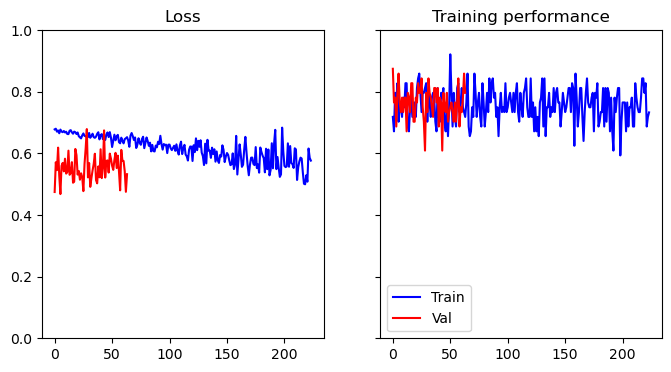

In [15]:
if not os.path.exists(DATA / "final_model.pth"):
    torch.manual_seed(42)
    model = train(1)
    # torch.save(model.state_dict(), DATA / "final_model.pth")
else:
    model = DTINetwork()
    model.load_state_dict(torch.load(DATA / "final_model.pth"))
    model.eval()

![TrainGraph](./images/train_perf.png)

*Figure 3:*
TDB

## Discussion

Wrap up the talktorial's content here and discuss pros/cons and open questions/challenges.

## Quiz

With this quiz you can test if you unterstand the important lessons of this talktorial.

1. Why do we use structual data instead of amino acid sequences and SMILES strings?
2. How do we convert proteins into graphs? What are the essential parts of proteins we use for that?
3. Difficult: Why do we need to implement our own class to represent data points?

<div class="alert alert-block alert-info">

<b>Useful checks at the end</b>: 
    
<ul>
<li>Clear output and rerun your complete notebook. Does it finish without errors?</li>
<li>Check if your talktorial's runtime is as excepted. If not, try to find out which step(s) take unexpectedly long.</li>
<li>Flag code cells with <code># NBVAL_CHECK_OUTPUT</code> that have deterministic output and should be tested within our Continuous Integration (CI) framework.</li>
</ul>

</div>